In [100]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [101]:
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [102]:
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20
BATCH_SIZE = 64

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 1024, 100, 3

Device: cpu


In [103]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [104]:
# Option A: single-folder dataset (no labels) -> good for GANs
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# If custom_transforms is already defined in your notebook, it will be used.
# Otherwise, you can use the same composition you had:
# custom_transforms = torchvision.transforms.Compose([ ... ])

class SingleFolderImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, extensions=('.jpg', '.jpeg', '.png', '.bmp')):
        self.paths = []
        for ext in extensions:
            self.paths += glob.glob(os.path.join(root_dir, f'*{ext}'))
        self.paths.sort()
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert('RGB')  # ensure 3 channels
        if self.transform:
            img = self.transform(img)
        return img

# --- USER ACTION: set this to your folder path where images live ---
DATA_DIR =  "/content/my_images"

from torchvision import transforms

custom_transforms = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean=0.5, std=0.5)
])
# create dataset
dataset = SingleFolderImageDataset(DATA_DIR, transform=custom_transforms)

# quick check
print("Number of images found:", len(dataset))

# split into train/val/test (80/10/10 split, change percentages if you want)
total = len(dataset)
train_len = int(0.8 * total)
val_len = int(0.1 * total)
test_len = total - train_len - val_len

# keep randomness reproducible
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len], generator=generator)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Create dataloaders -> train:", len(train_dataset), "val:", len(valid_dataset), "test:", len(test_dataset))

Number of images found: 100
Create dataloaders -> train: 80 val: 10 test: 10


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [105]:
print('Training Set:\n')
for images in train_loader:
    print('Image batch dimensions:', images.size())
    break


# Checking the dataset
print('\nValidation Set:')
for images in valid_loader:
    print('Image batch dimensions:', images.size())
    break

# Checking the dataset
print('\nTesting Set:')
for images in test_loader:
    print('Image batch dimensions:', images.size())
    break

Training Set:



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Image batch dimensions: torch.Size([64, 3, 256, 256])

Validation Set:
Image batch dimensions: torch.Size([10, 3, 256, 256])

Testing Set:
Image batch dimensions: torch.Size([10, 3, 256, 256])


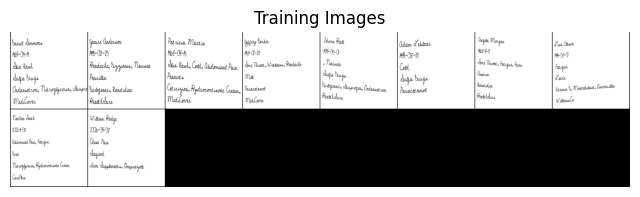

In [106]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))

In [107]:
print(images.shape)

torch.Size([10, 3, 256, 256])


In [108]:
print("Number of images in dataset:", len(dataset))


Number of images in dataset: 100


In [109]:
print("Batch shape:", images.shape)


Batch shape: torch.Size([10, 3, 256, 256])


In [110]:
"""class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()


        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8,
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.ReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.ReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.ReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.ReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),

            # size: 1 x 1 x 1
            nn.Flatten(),

        )


    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
      logits = self.discriminator(img)
      return logits"""

'class DCGAN(torch.nn.Module):\n\n    def __init__(self, latent_dim=100, \n                 num_feat_maps_gen=64, num_feat_maps_dis=64,\n                 color_channels=3):\n        super().__init__()\n        \n        \n        self.generator = nn.Sequential(\n            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, \n                               kernel_size=4, stride=1, padding=0,\n                               bias=False),\n            nn.BatchNorm2d(num_feat_maps_gen*8),\n            nn.ReLU(inplace=True),\n            #\n            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4\n            #\n            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, \n                               kernel_size=4, stride=2, padding=1,\n                               bias=False),\n            nn.BatchNorm2d(num_feat_maps_gen*4),\n            nn.ReLU(inplace=True),\n            #\n            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8\n            #\n    

In [111]:
set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DCGAN(nn.Module):
    def __init__(self, latent_dim=100, num_feat_maps_gen=64, num_feat_maps_dis=64, color_channels=3):
        super().__init__()

        # Generator (unchanged from your working version)
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        # CORRECTED Discriminator
        self.discriminator = nn.Sequential(
            # Input: 3 x 64 x 64 (generator output size)
            nn.Conv2d(color_channels, num_feat_maps_dis, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 32 x 32

            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 16 x 16

            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 256 x 8 x 8

            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 512 x 4 x 4

            nn.Conv2d(num_feat_maps_dis*8, 1, kernel_size=4, stride=1, padding=0),
            # Output: 1 x 1 x 1

            # Remove the Flatten() and Linear layers - use adaptive pooling instead
            nn.AdaptiveAvgPool2d(1),  # Ensures output is [batch_size, 1, 1, 1]
            nn.Flatten()  # Converts to [batch_size, 1]
        )

    def generator_forward(self, z):
        return self.generator(z)

    def discriminator_forward(self, img):
        return self.discriminator(img)




In [164]:
import time
import torch
import torch.nn.functional as F
import torchvision


In [165]:
import time
import torch
import torch.nn.functional as F
import torchvision

def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, images in enumerate(train_loader):  # Only unpack images, no labels

            batch_size = images.size(0)

            # real images
            real_images = images.to(device)
            real_labels = torch.ones(batch_size, device=device).unsqueeze(1) # real label = 1, reshape to [batch_size, 1]

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device).unsqueeze(1) # fake label = 0, reshape to [batch_size, 1]
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images)  # Flatten happens inside the model
            real_loss = loss_fn(discr_pred_real, real_labels)

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach())  # Flatten happens inside the model
            fake_loss = loss_fn(discr_pred_fake, fake_labels)

            # combined loss
            discr_loss = 0.5 * (real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images)  # Flatten happens inside the model
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean() * 100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean() * 100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader):03d} | Gen/Dis Loss: {gener_loss.item():.4f}/{discr_loss.item():.4f}')

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))

        print(f'Time elapsed: {((time.time() - start_time) / 60):.2f} min')

    print(f'Total Training Time: {((time.time() - start_time) / 60):.2f} min')

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [166]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


In [167]:
optim_gen = torch.optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [168]:
model = DCGAN(latent_dim=100).to(DEVICE)  # Initialize the model and move it to the appropriate device


In [169]:
log_dict = train_gan_v1(
    num_epochs=NUM_EPOCHS,
    model=model,
    optimizer_gen=optim_gen,
    optimizer_discr=optim_discr,
    device=DEVICE,
    train_loader=train_loader,
    logging_interval=100,
    save_model='gan_celebA_01.pt',
    latent_dim=100  # Add this argument to specify the latent dimension
)


Epoch: 001/020 | Batch 000/002 | Gen/Dis Loss: 0.6088/0.7171
Time elapsed: 0.61 min
Epoch: 002/020 | Batch 000/002 | Gen/Dis Loss: 0.6148/0.7205
Time elapsed: 1.17 min
Epoch: 003/020 | Batch 000/002 | Gen/Dis Loss: 0.5598/0.7511
Time elapsed: 1.74 min
Epoch: 004/020 | Batch 000/002 | Gen/Dis Loss: 0.5781/0.7396
Time elapsed: 2.30 min
Epoch: 005/020 | Batch 000/002 | Gen/Dis Loss: 0.5907/0.7356
Time elapsed: 2.87 min
Epoch: 006/020 | Batch 000/002 | Gen/Dis Loss: 0.6078/0.7225
Time elapsed: 3.43 min
Epoch: 007/020 | Batch 000/002 | Gen/Dis Loss: 0.5872/0.7343
Time elapsed: 3.98 min
Epoch: 008/020 | Batch 000/002 | Gen/Dis Loss: 0.5870/0.7359
Time elapsed: 4.56 min
Epoch: 009/020 | Batch 000/002 | Gen/Dis Loss: 0.6544/0.6972
Time elapsed: 5.13 min
Epoch: 010/020 | Batch 000/002 | Gen/Dis Loss: 0.6151/0.7130
Time elapsed: 5.70 min
Epoch: 011/020 | Batch 000/002 | Gen/Dis Loss: 0.6010/0.7276
Time elapsed: 6.28 min
Epoch: 012/020 | Batch 000/002 | Gen/Dis Loss: 0.5774/0.7402
Time elapsed: 6

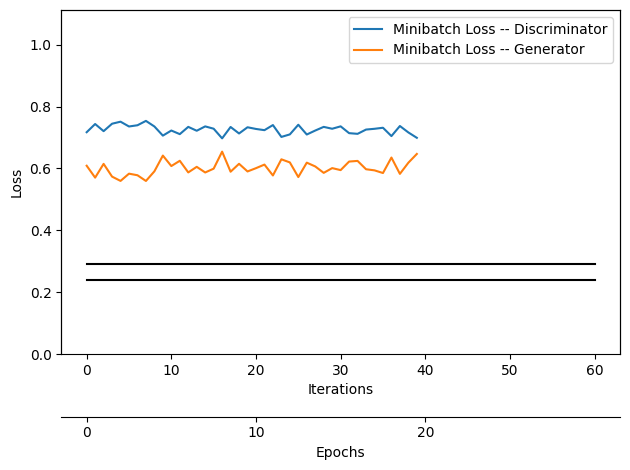

In [170]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

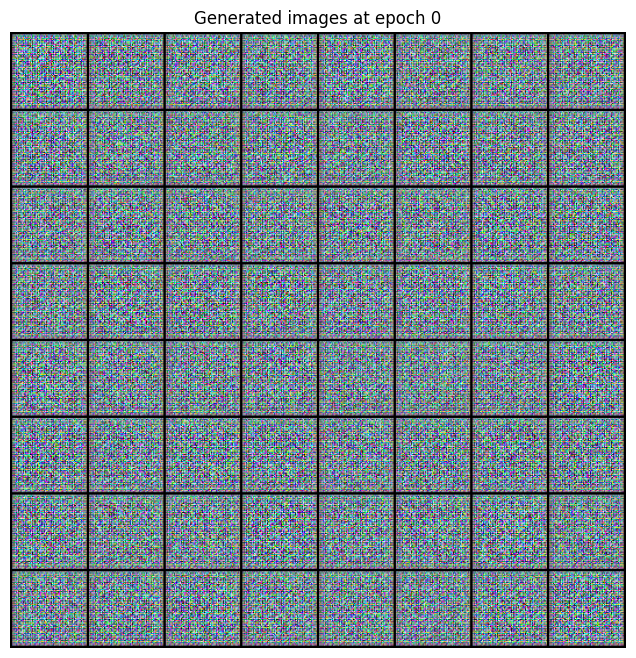

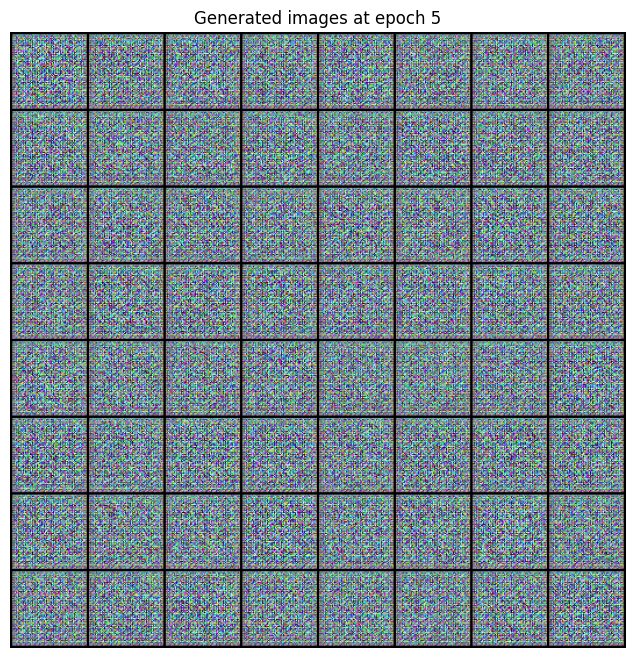

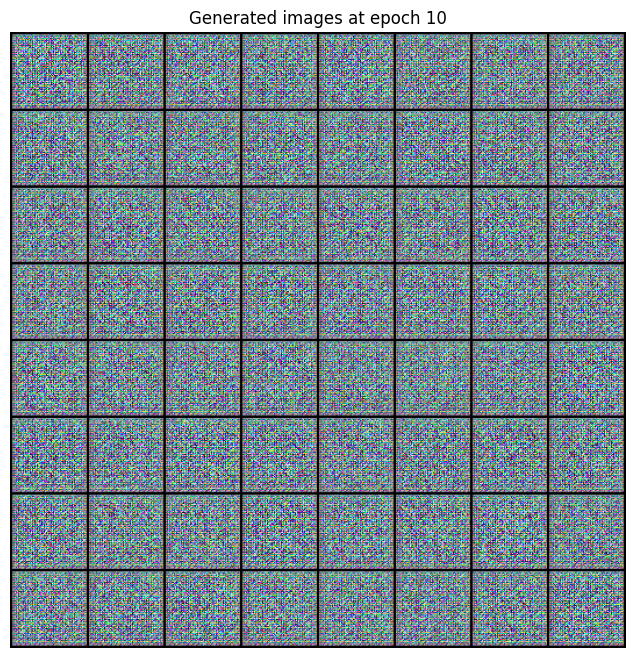

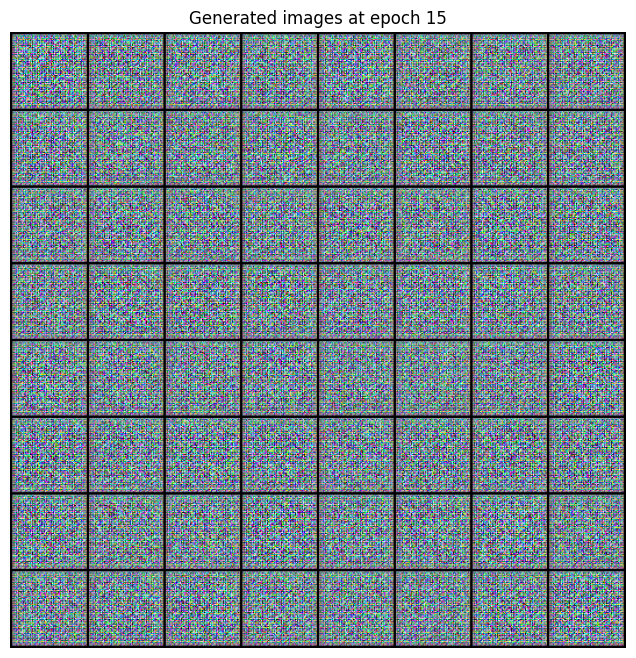

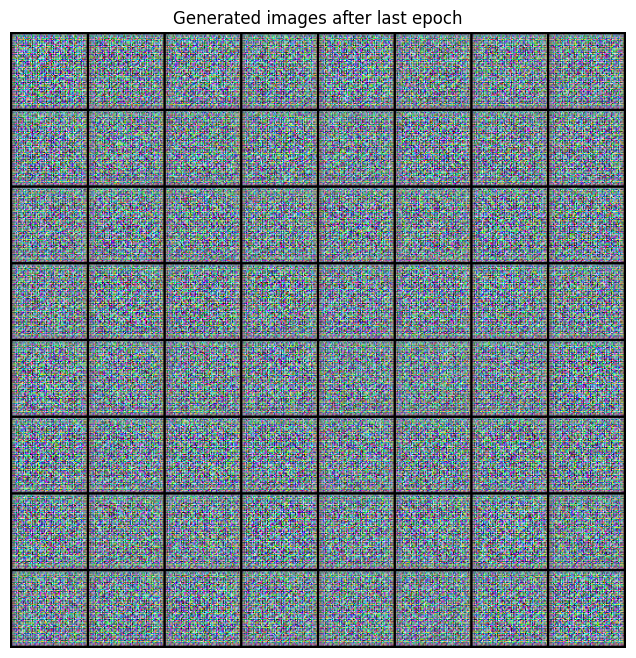

In [171]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

In [172]:
# Load the trained model
model = DCGAN().to(DEVICE)
model.load_state_dict(torch.load('gan_celebA_01.pt'))
model.eval()  # Set to evaluation mode

DCGAN(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
 

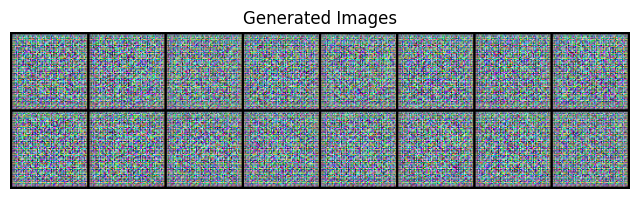

In [173]:
def generate_images(model, num_images=64, latent_dim=100, device=DEVICE):
    """Generate new images using the trained generator"""
    # Create random noise
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = model.generator_forward(noise)

    return generated_images

# Generate some images
generated_imgs = generate_images(model, num_images=16)

# Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    generated_imgs, padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [174]:
def test_discriminator(model, test_loader, device=DEVICE):
    """Test discriminator on real and fake images"""
    model.eval()

    real_accuracies = []
    fake_accuracies = []

    with torch.no_grad():
        for batch_idx, real_images in enumerate(test_loader):
            batch_size = real_images.size(0)

            # Test on real images
            real_images = real_images.to(device)
            real_labels = torch.ones(batch_size, device=device)
            discr_pred_real = model.discriminator_forward(real_images)
            predicted_real = torch.where(discr_pred_real > 0., 1., 0.)
            real_acc = (predicted_real == real_labels).float().mean().item() * 100
            real_accuracies.append(real_acc)

            # Test on fake images
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device)
            discr_pred_fake = model.discriminator_forward(fake_images)
            predicted_fake = torch.where(discr_pred_fake > 0., 1., 0.)
            fake_acc = (predicted_fake == fake_labels).float().mean().item() * 100
            fake_accuracies.append(fake_acc)

            # Only test a few batches
            if batch_idx >= 5:
                break

    print(f"Discriminator Real Image Accuracy: {np.mean(real_accuracies):.2f}%")
    print(f"Discriminator Fake Image Accuracy: {np.mean(fake_accuracies):.2f}%")

# Test the discriminator
test_discriminator(model, test_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Discriminator Real Image Accuracy: 90.00%
Discriminator Fake Image Accuracy: 40.00%


In [175]:
def save_generated_images(model, num_images=100, save_dir='generated_images', latent_dim=100):
    """Generate and save images to a directory"""
    import os
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        # Generate in batches
        for i in range(0, num_images, 16):
            batch_size = min(16, num_images - i)
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=DEVICE)
            generated = model.generator_forward(noise)

            # Save each image
            for j in range(batch_size):
                img = generated[j].cpu()
                img = (img + 1) / 2  # Convert from [-1,1] to [0,1]
                img = transforms.ToPILImage()(img)
                img.save(os.path.join(save_dir, f'generated_{i+j:04d}.png'))

    print(f"Saved {num_images} generated images to {save_dir}/")

# Save some generated images
save_generated_images(model, num_images=100, save_dir='my_generated_images')

Saved 100 generated images to my_generated_images/


In [176]:
def create_training_gif(log_dict, save_path='training_progress.gif'):
    """Create a GIF showing the training progress"""
    from PIL import Image
    import imageio

    images = []
    for img_grid in log_dict['images_from_noise_per_epoch']:
        # Convert tensor to PIL Image
        img = img_grid.numpy().transpose(1, 2, 0)
        img = (img * 255).astype('uint8')
        images.append(Image.fromarray(img))

    # Save as GIF
    images[0].save(save_path, save_all=True, append_images=images[1:],
                   duration=500, loop=0)
    print(f"Training progress GIF saved as {save_path}")

# Create training progress GIF
create_training_gif(log_dict)

Training progress GIF saved as training_progress.gif


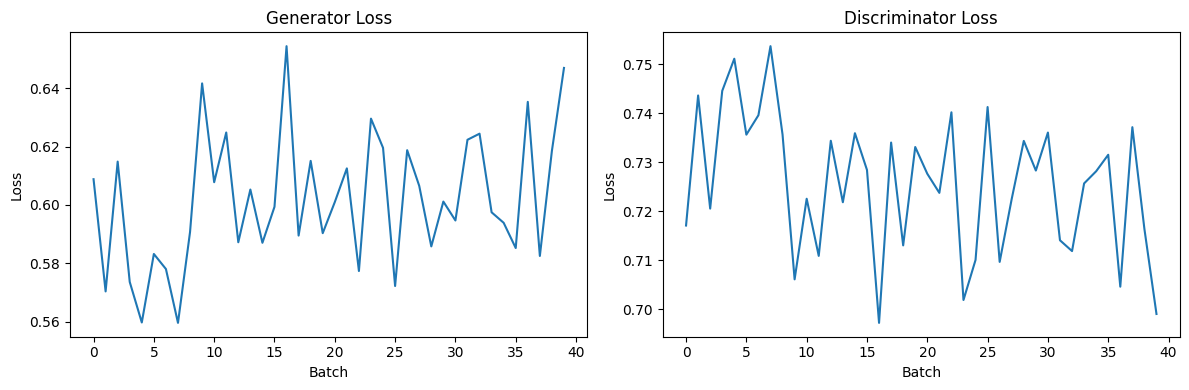

In [177]:
# Plot the training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(log_dict['train_generator_loss_per_batch'])
plt.title('Generator Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(log_dict['train_discriminator_loss_per_batch'])
plt.title('Discriminator Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [180]:
def calculate_fid_score(real_loader, model, num_images=1000, device=DEVICE):
    """Calculate FID score (needs torch-fidelity package)"""
    try:
        from torch_fidelity import calculate_metrics
        import tempfile
        import os

        # Generate fake images
        fake_images = []
        with torch.no_grad():
            for i in range(0, num_images, 64):
                batch_size = min(64, num_images - i)
                noise = torch.randn(batch_size, 100, 1, 1, device=device)
                generated = model.generator_forward(noise)
                fake_images.append(generated.cpu())

        fake_images = torch.cat(fake_images, dim=0)

        # Calculate FID (this is a simplified version)
        # For proper FID calculation, you'd need to install torch-fidelity
        print("FID calculation requires torch-fidelity package")
        print("Install with: pip install torch-fidelity")

    except ImportError:
        print("torch-fidelity not installed. Install it for FID calculation.")

calculate_fid_score(train_loader, model)

torch-fidelity not installed. Install it for FID calculation.


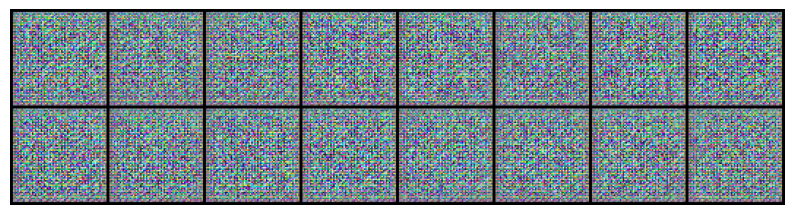

In [181]:
# Simple image generation
model.eval()
with torch.no_grad():
    noise = torch.randn(16, 100, 1, 1, device=DEVICE)
    generated = model.generator_forward(noise)

# Display
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    generated, padding=2, normalize=True), (1, 2, 0)))
plt.show()